# Library Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, roc_auc_score, classification_report)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
import missingno as msno

# Display options

In [4]:
flag = 0
if flag == 1:   
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
else:
    pd.reset_option('display.max_rows', None)
    pd.reset_option('display.max_columns', None)

# Load Original Dataset

In [5]:
data_path = '..\\Dataset\\churn_telecom.csv'
df_churn = pd.read_csv(data_path)

In [6]:
df_churn

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [7]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<Axes: >

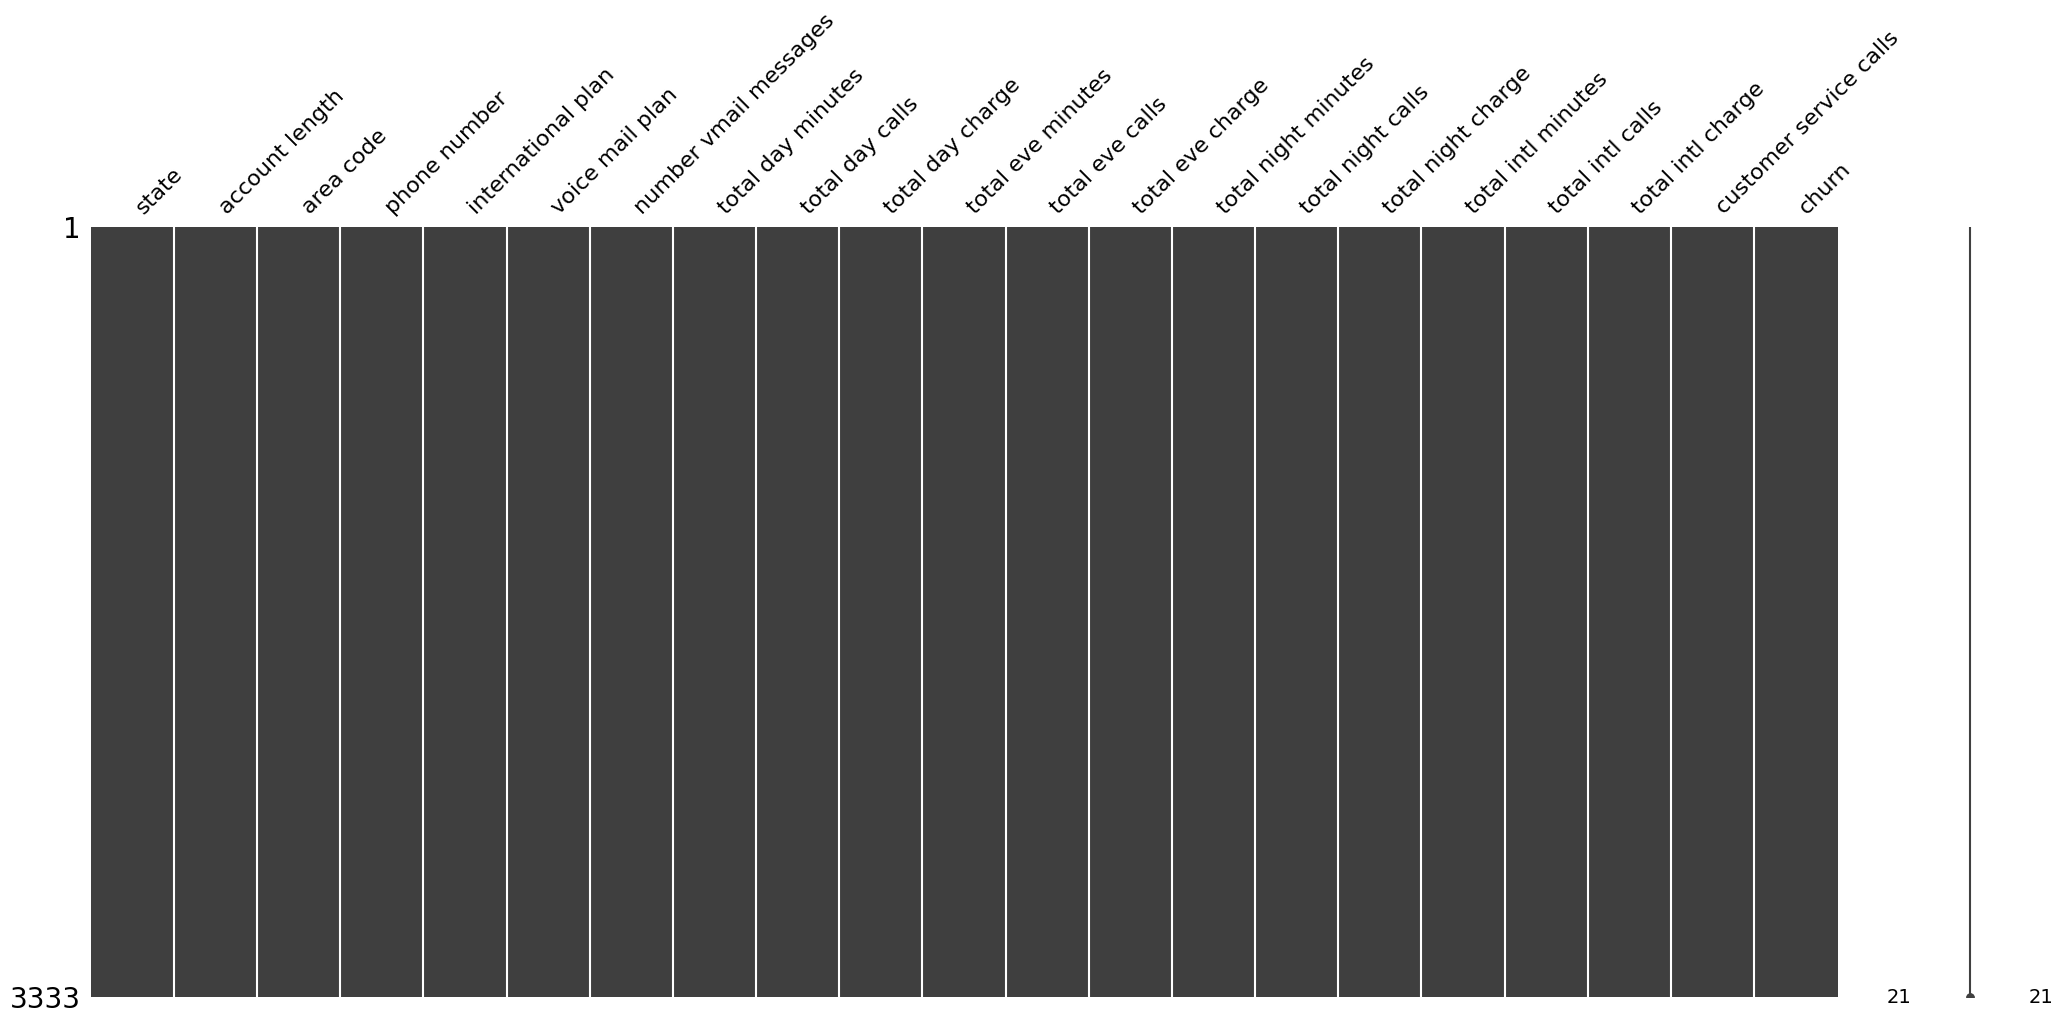

In [8]:
msno.matrix(df_churn)

In [9]:
print(f'Duplicate rows: {df_churn.duplicated().sum()}')

Duplicate rows: 0


# Churn Percentage Analysis

In [10]:
churn_percentage = df_churn['churn'].value_counts(normalize=True) * 100
print(churn_percentage)

churn
False    85.508551
True     14.491449
Name: proportion, dtype: float64


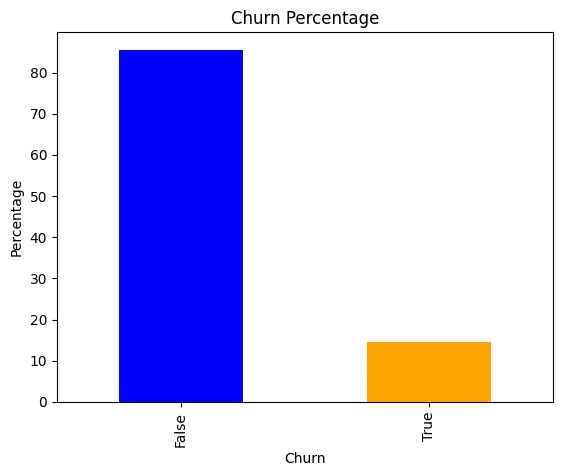

In [11]:
churn_percentage.plot(kind='bar', color=['blue', 'orange'])
plt.title('Churn Percentage')
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.show()

In [12]:
df_churn_origin = df_churn.copy()
df_churn_origin_nbc = df_churn.copy()

In [13]:
la = LabelEncoder()
binary_columns = [col for col in df_churn_origin.columns if df_churn_origin[col].nunique() == 2]

for col in binary_columns:
    df_churn_origin[col] = la.fit_transform(df_churn_origin[col])

In [14]:
df_churn_origin['area code'] = df_churn_origin['area code'].astype('object')

In [15]:
df_churn_origin = pd.get_dummies(df_churn_origin, columns=['area code', 'state'])

In [16]:
df_churn_origin.drop(columns=['phone number'], inplace=True)

In [17]:
df_churn_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   international plan      3333 non-null   int32  
 2   voice mail plan         3333 non-null   int32  
 3   number vmail messages   3333 non-null   int64  
 4   total day minutes       3333 non-null   float64
 5   total day calls         3333 non-null   int64  
 6   total day charge        3333 non-null   float64
 7   total eve minutes       3333 non-null   float64
 8   total eve calls         3333 non-null   int64  
 9   total eve charge        3333 non-null   float64
 10  total night minutes     3333 non-null   float64
 11  total night calls       3333 non-null   int64  
 12  total night charge      3333 non-null   float64
 13  total intl minutes      3333 non-null   float64
 14  total intl calls        3333 non-null   

# Feature Construction with Equidistant Grouping

In [18]:
df_churn_v1 = df_churn.copy()
columns_to_extract = [
    'number vmail messages', 'total day minutes', 'total day calls',
    'total day charge', 'total night minutes', 'total night calls',
    'total night charge', 'total eve minutes', 'total eve calls',
    'total eve charge', 'total intl minutes', 'total intl calls'
]

In [19]:
df_extracted = df_churn_v1[columns_to_extract]
df_extracted

,number vmail messages,total day minutes,total day calls,total day charge,total night minutes,total night calls,total night charge,total eve minutes,total eve calls,total eve charge,total intl minutes,total intl calls
0,25,265.1,110,45.07,244.7,91,11.01,197.4,99,16.78,10.0,3
1,26,161.6,123,27.47,254.4,103,11.45,195.5,103,16.62,13.7,3
2,0,243.4,114,41.38,162.6,104,7.32,121.2,110,10.30,12.2,5
3,0,299.4,71,50.90,196.9,89,8.86,61.9,88,5.26,6.6,7
4,0,166.7,113,28.34,186.9,121,8.41,148.3,122,12.61,10.1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,36,156.2,77,26.55,279.1,83,12.56,215.5,126,18.32,9.9,6
3329,0,231.1,57,39.29,191.3,123,8.61,153.4,55,13.04,9.6,4
3330,0,180.8,109,30.74,191.9,91,8.64,288.8,58,24.55,14.1,6
3331,0,213.8,105,36.35,139.2,137,6.26,159.6,84,13.57,5.0,10


In [20]:
# Function to calculate Sturges' formula
def Sturges_formula(n):
    return round(1 + np.log2(n))

In [21]:
# Function to create bins for features
def create_bins(feature):
    num_bins = Sturges_formula(feature.max() - feature.min())
    min_val = feature.min()
    max_val = feature.max()
    bins = np.linspace(start=min_val, stop=max_val, num=num_bins+1)
    print(bins)
    return bins

In [22]:
# Creating bins for each extracted column
for col in df_extracted.columns:
    bins = create_bins(df_extracted[col])
    feature = df_extracted[col].values
    df_extracted[col] = np.digitize(feature, bins)

[ 0.          7.28571429 14.57142857 21.85714286 29.14285714 36.42857143
 43.71428571 51.        ]
[  0.          38.97777778  77.95555556 116.93333333 155.91111111
 194.88888889 233.86666667 272.84444444 311.82222222 350.8       ]
[  0.     20.625  41.25   61.875  82.5   103.125 123.75  144.375 165.   ]
[ 0.    8.52 17.04 25.56 34.08 42.6  51.12 59.64]
[ 23.2   60.38  97.56 134.74 171.92 209.1  246.28 283.46 320.64 357.82
 395.  ]
[ 33.    50.75  68.5   86.25 104.   121.75 139.5  157.25 175.  ]
[ 1.04   4.386  7.732 11.078 14.424 17.77 ]
[  0.    36.37  72.74 109.11 145.48 181.85 218.22 254.59 290.96 327.33
 363.7 ]
[  0.    21.25  42.5   63.75  85.   106.25 127.5  148.75 170.  ]
[ 0.          5.15166667 10.30333333 15.455      20.60666667 25.75833333
 30.91      ]
[ 0.  4.  8. 12. 16. 20.]
[ 0.  4.  8. 12. 16. 20.]


C:\Users\Leo\AppData\Local\Temp\ipykernel_22404\523815762.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extracted[col] = np.digitize(feature, bins)


In [23]:
df_extracted_v1 = df_extracted.copy()
df_extracted_v1.columns = df_extracted_v1.columns.map(lambda x: f"{x} group")

df_extracted_v1

,number vmail messages group,total day minutes group,total day calls group,total day charge group,total night minutes group,total night calls group,total night charge group,total eve minutes group,total eve calls group,total eve charge group,total intl minutes group,total intl calls group
0,4,7,6,6,6,4,3,6,5,4,3,1
1,4,5,6,4,7,4,4,6,5,4,4,1
2,1,7,6,5,4,5,2,4,6,2,4,2
3,1,8,4,6,5,4,3,2,5,2,2,2
4,1,5,6,4,5,5,3,5,6,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,5,5,4,4,7,3,4,6,6,4,3,2
3329,1,6,3,5,5,6,3,5,3,3,3,2
3330,1,5,6,4,5,4,3,8,3,5,4,2
3331,1,6,6,5,4,6,2,5,4,3,2,3


# New Dataset

In [24]:
df_churn_v2 = pd.concat([df_churn_v1, df_extracted_v1], axis=1)
df_churn_v2

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total day calls group,total day charge group,total night minutes group,total night calls group,total night charge group,total eve minutes group,total eve calls group,total eve charge group,total intl minutes group,total intl calls group
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,6,6,6,4,3,6,5,4,3,1
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,6,4,7,4,4,6,5,4,4,1
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,6,5,4,5,2,4,6,2,4,2
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,4,6,5,4,3,2,5,2,2,2
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,6,4,5,5,3,5,6,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,4,4,7,3,4,6,6,4,3,2
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,3,5,5,6,3,5,3,3,3,2
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,6,4,5,4,3,8,3,5,4,2
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,6,5,4,6,2,5,4,3,2,3


In [25]:
df_churn_new_nbc = df_churn_v2.copy()

In [26]:
la = LabelEncoder()

binary_columns = [col for col in df_churn_v2.columns if df_churn_v2[col].nunique() == 2]
for col in binary_columns:
    df_churn_v2[col] = la.fit_transform(df_churn_v2[col])

In [27]:
df_churn_v2['area code'] = df_churn_v2['area code'].astype('object')

In [28]:
df_churn_v3 = pd.get_dummies(df_churn_v2, columns=['area code', 'state'])

In [29]:
df_churn_v3.drop(columns=['phone number'], inplace=True)

In [30]:
df_churn_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 84 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   account length               3333 non-null   int64  
 1   international plan           3333 non-null   int32  
 2   voice mail plan              3333 non-null   int32  
 3   number vmail messages        3333 non-null   int64  
 4   total day minutes            3333 non-null   float64
 5   total day calls              3333 non-null   int64  
 6   total day charge             3333 non-null   float64
 7   total eve minutes            3333 non-null   float64
 8   total eve calls              3333 non-null   int64  
 9   total eve charge             3333 non-null   float64
 10  total night minutes          3333 non-null   float64
 11  total night calls            3333 non-null   int64  
 12  total night charge           3333 non-null   float64
 13  total intl minutes

# Prepare for modeling

In [31]:
X = df_churn_v3.drop(['churn'], axis=1)  
y = df_churn_v3['churn']

In [32]:
X

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,False,False,False,False,False,False,False,False,False,False
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,False,False,False,False,False,False,False,False,False,False
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,False,False,False,False,False,False,False,False,False,False
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,False,False,False,False,False,False,False,False,False,False
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,26.55,215.5,126,18.32,...,False,False,False,False,False,False,False,False,False,False
3329,68,0,0,0,231.1,57,39.29,153.4,55,13.04,...,False,False,False,False,False,False,False,False,True,False
3330,28,0,0,0,180.8,109,30.74,288.8,58,24.55,...,False,False,False,False,False,False,False,False,False,False
3331,184,1,0,0,213.8,105,36.35,159.6,84,13.57,...,False,False,False,False,False,False,False,False,False,False


In [33]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
817,243,0,0,0,95.5,92,16.24,163.7,63,13.91,...,False,False,False,True,False,False,False,False,False,False
1373,108,0,0,0,112.0,105,19.04,193.7,110,16.46,...,False,False,False,False,False,False,False,False,False,False
679,75,1,0,0,222.4,78,37.81,327.0,111,27.80,...,False,False,True,False,False,False,False,False,False,False
56,141,0,0,0,126.9,98,21.57,180.0,62,15.30,...,False,False,False,False,False,False,False,False,False,False
1993,86,0,0,0,216.3,96,36.77,266.3,77,22.64,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,106,0,0,0,274.4,120,46.65,198.6,82,16.88,...,False,False,False,False,False,False,False,False,False,False
1130,122,0,0,0,35.1,62,5.97,180.8,89,15.37,...,False,False,False,False,False,False,False,False,False,False
1294,66,0,0,0,87.6,76,14.89,262.0,111,22.27,...,False,False,False,False,False,False,False,False,False,False
860,169,0,0,0,179.2,111,30.46,175.2,130,14.89,...,False,False,False,False,False,False,False,False,False,False


In [35]:
X_test

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
438,113,0,0,0,155.0,93,26.35,330.6,106,28.10,...,False,False,False,False,False,False,False,False,False,True
2674,67,0,0,0,109.1,117,18.55,217.4,124,18.48,...,False,False,False,False,False,False,False,False,False,False
1345,98,0,0,0,0.0,0,0.00,159.6,130,13.57,...,True,False,False,False,False,False,False,False,False,False
1957,147,0,0,0,212.8,79,36.18,204.1,91,17.35,...,False,False,False,False,False,False,False,False,False,False
2148,96,0,0,0,144.0,102,24.48,224.7,73,19.10,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,157,0,0,0,185.1,92,31.47,213.0,85,18.11,...,False,False,False,False,False,False,False,False,False,False
2763,116,0,1,19,155.7,104,26.47,185.4,118,15.76,...,False,False,False,False,False,False,False,False,False,False
3069,148,0,1,26,158.7,91,26.98,160.5,127,13.64,...,False,False,False,False,False,False,False,False,False,False
1468,75,0,1,27,117.5,102,19.98,206.8,127,17.58,...,False,False,False,False,False,False,False,False,False,False


In [36]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [37]:
X_train_smote

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,243,0,0,0,95.500000,92,16.240000,163.700000,63,13.910000,...,False,False,False,True,False,False,False,False,False,False
1,108,0,0,0,112.000000,105,19.040000,193.700000,110,16.460000,...,False,False,False,False,False,False,False,False,False,False
2,75,1,0,0,222.400000,78,37.810000,327.000000,111,27.800000,...,False,False,True,False,False,False,False,False,False,False
3,141,0,0,0,126.900000,98,21.570000,180.000000,62,15.300000,...,False,False,False,False,False,False,False,False,False,False
4,86,0,0,0,216.300000,96,36.770000,266.300000,77,22.640000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4563,131,0,1,35,227.995773,101,38.755697,180.670973,124,15.360592,...,False,False,False,False,False,False,False,False,False,False
4564,132,0,0,0,181.964646,108,30.931945,172.295730,100,14.644593,...,False,False,False,False,False,False,False,False,False,False
4565,100,0,0,0,324.749577,107,55.206428,165.968237,104,14.104420,...,False,False,False,False,False,False,False,True,False,False
4566,157,0,0,20,215.170474,119,36.576054,310.380625,93,26.380256,...,False,False,False,False,False,False,False,False,False,False


## Logistic Regression (LR)

In [38]:
log_reg = LogisticRegression(class_weight='balanced')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],       
    'penalty': ['l1', 'l2'],       
    'solver': ['liblinear', 'newton-cholesky'],             
    'max_iter': [100, 200, 500],
}

grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

logreg_best_params = grid_search.best_params_
print(f"Best parameters: {logreg_best_params}")

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cholesky'}


c:\Users\Leo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Leo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Leo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Leo\AppData\Loc

In [39]:
logreg_optimized = LogisticRegression(**logreg_best_params, class_weight='balanced')
logreg_optimized.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cholesky')

In [81]:
y_pred_log_reg = logreg_optimized.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_log_reg)

print(roc_auc_score(y_test, y_pred_log_reg))
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_log_reg))

0.7601633838295491
Accuracy: 0.7586206896551724
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       566
           1       0.36      0.76      0.49       101

    accuracy                           0.76       667
   macro avg       0.65      0.76      0.67       667
weighted avg       0.86      0.76      0.79       667



## Decision Tree Classifier (DTC)

In [83]:
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
}

grid_search = GridSearchCV(dt_classifier, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

dtc_best_params = grid_search.best_params_
print(f"Best parameters: {dtc_best_params}")

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}


In [84]:
dt_classifier_optimized = DecisionTreeClassifier(**dtc_best_params, random_state=42, class_weight='balanced')
dt_classifier_optimized.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=7,
                       random_state=42)

In [85]:
y_pred_dtc = dt_classifier_optimized.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dtc)

print(roc_auc_score(y_test, y_pred_dtc))
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_dtc))

0.8850890389392296
Accuracy: 0.9430284857571214
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       566
           1       0.82      0.80      0.81       101

    accuracy                           0.94       667
   macro avg       0.89      0.89      0.89       667
weighted avg       0.94      0.94      0.94       667



## Naive Bayes Classifier

In [44]:
df_churn_new_nbc

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total day calls group,total day charge group,total night minutes group,total night calls group,total night charge group,total eve minutes group,total eve calls group,total eve charge group,total intl minutes group,total intl calls group
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,6,6,6,4,3,6,5,4,3,1
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,6,4,7,4,4,6,5,4,4,1
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,6,5,4,5,2,4,6,2,4,2
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,4,6,5,4,3,2,5,2,2,2
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,6,4,5,5,3,5,6,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,4,4,7,3,4,6,6,4,3,2
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,3,5,5,6,3,5,3,3,3,2
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,6,4,5,4,3,8,3,5,4,2
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,6,5,4,6,2,5,4,3,2,3


In [45]:
df_churn_new_nbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        3333 non-null   object 
 1   account length               3333 non-null   int64  
 2   area code                    3333 non-null   int64  
 3   phone number                 3333 non-null   object 
 4   international plan           3333 non-null   object 
 5   voice mail plan              3333 non-null   object 
 6   number vmail messages        3333 non-null   int64  
 7   total day minutes            3333 non-null   float64
 8   total day calls              3333 non-null   int64  
 9   total day charge             3333 non-null   float64
 10  total eve minutes            3333 non-null   float64
 11  total eve calls              3333 non-null   int64  
 12  total eve charge             3333 non-null   float64
 13  total night minute

In [46]:
la = LabelEncoder()
binary_columns = [col for col in df_churn_new_nbc.columns if df_churn_new_nbc[col].nunique() == 2]

for col in binary_columns:
    df_churn_new_nbc[col] = la.fit_transform(df_churn_new_nbc[col])

In [47]:
df_churn_new_nbc['area code'] = df_churn_new_nbc['area code'].astype('object')

In [48]:
df_churn_new_nbc = pd.get_dummies(df_churn_new_nbc, columns=['area code', 'state'])

In [49]:
df_churn_new_nbc.drop(columns=['phone number'], inplace=True)

In [50]:
df_churn_new_nbc

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,False,False,False,False,False,False,False,False,False,False
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,False,False,False,False,False,False,False,False,False,False
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,False,False,False,False,False,False,False,False,False,False
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,False,False,False,False,False,False,False,False,False,False
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,26.55,215.5,126,18.32,...,False,False,False,False,False,False,False,False,False,False
3329,68,0,0,0,231.1,57,39.29,153.4,55,13.04,...,False,False,False,False,False,False,False,False,True,False
3330,28,0,0,0,180.8,109,30.74,288.8,58,24.55,...,False,False,False,False,False,False,False,False,False,False
3331,184,1,0,0,213.8,105,36.35,159.6,84,13.57,...,False,False,False,False,False,False,False,False,False,False


In [51]:
continuous_cols = ['total day minutes',
                   'total day charge', 
                   'total eve minutes',
                   'total eve charge',
                   'total night minutes',
                   'total night charge', 
                   'total intl minutes',
                   'total intl charge']

discrete_cols = ['account length', 
                 'total day calls',
                'total eve calls',
                'total night calls',
                'total intl calls',
                'customer service calls',
                'number vmail messages']

In [52]:
X_nbc = df_churn_new_nbc.drop(['churn'], axis=1)  
y_nbc = df_churn_new_nbc['churn']

In [53]:
X_train_nbc, X_test_nbc, y_train_nbc, y_test_nbc = train_test_split(X_nbc, y_nbc, test_size=0.2, random_state=42, stratify=y_nbc)

In [54]:
X_train_nbc

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
3286,106,0,1,30,220.1,105,37.42,222.2,109,18.89,...,False,False,False,False,False,False,False,False,False,False
86,94,0,0,0,157.9,105,26.84,155.0,101,13.18,...,False,False,False,False,False,False,False,False,False,False
1349,71,0,1,22,141.4,107,24.04,163.0,105,13.86,...,False,False,False,False,False,False,False,False,False,False
1649,130,0,0,0,68.4,86,11.63,193.3,110,16.43,...,False,False,False,False,False,False,False,False,False,False
3000,87,0,0,0,223.2,109,37.94,127.5,86,10.84,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,116,0,1,12,221.0,108,37.57,151.0,118,12.84,...,False,False,False,False,False,False,False,False,False,True
2165,160,0,0,0,171.2,103,29.10,243.5,121,20.70,...,False,False,False,False,False,False,False,False,False,False
2988,105,0,0,0,259.3,96,44.08,175.2,97,14.89,...,False,False,False,False,True,False,False,False,False,False
179,70,0,0,0,232.1,122,39.46,292.3,112,24.85,...,False,False,False,False,False,False,False,False,False,False


In [55]:
X_test_nbc

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
601,62,1,0,0,159.7,86,27.15,197.5,76,16.79,...,False,False,False,False,False,False,False,False,False,False
2050,121,0,0,0,213.2,79,36.24,120.7,116,10.26,...,False,False,False,False,False,False,False,False,False,False
3200,100,1,0,0,107.2,98,18.22,86.8,122,7.38,...,False,False,False,False,False,False,False,False,False,False
1953,137,0,0,0,208.8,120,35.50,225.3,100,19.15,...,False,False,False,False,False,False,True,False,False,False
1119,189,0,0,0,208.3,106,35.41,236.7,123,20.12,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,84,0,0,0,216.1,114,36.74,197.5,107,16.79,...,False,False,False,False,False,False,False,False,False,False
1763,93,0,1,42,166.9,101,28.37,273.2,84,23.22,...,False,False,False,False,False,False,False,False,False,True
950,108,0,0,0,103.0,129,17.51,242.3,103,20.60,...,False,False,False,False,False,False,False,False,False,False
1652,176,0,1,23,283.2,130,48.14,162.6,74,13.82,...,False,True,False,False,False,False,False,False,False,False


In [56]:
smote = SMOTE(random_state=42)
X_train_nbc_smote, y_train_nbc_smote = smote.fit_resample(X_train_nbc, y_train_nbc)

In [57]:
X_train_nbc_smote

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,106,0,1,30,220.100000,105,37.420000,222.200000,109,18.890000,...,False,False,False,False,False,False,False,False,False,False
1,94,0,0,0,157.900000,105,26.840000,155.000000,101,13.180000,...,False,False,False,False,False,False,False,False,False,False
2,71,0,1,22,141.400000,107,24.040000,163.000000,105,13.860000,...,False,False,False,False,False,False,False,False,False,False
3,130,0,0,0,68.400000,86,11.630000,193.300000,110,16.430000,...,False,False,False,False,False,False,False,False,False,False
4,87,0,0,0,223.200000,109,37.940000,127.500000,86,10.840000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,106,0,1,39,176.566204,93,30.017933,120.846109,104,10.273306,...,True,False,False,False,False,False,False,False,False,False
4556,142,0,0,0,55.845120,90,9.495728,247.192993,97,21.010225,...,False,False,False,False,False,False,True,False,False,False
4557,69,0,0,0,155.471782,132,26.430553,193.310733,117,16.435175,...,False,False,False,False,False,False,False,False,False,False
4558,171,0,0,0,246.425850,63,41.894879,299.360081,123,25.446802,...,False,False,False,False,False,False,False,False,False,False


In [58]:
all_columns = set(X_train_nbc_smote.columns)
categorical_columns = all_columns - set(continuous_cols) - set(discrete_cols)

X_cont_train = X_train_nbc_smote[continuous_cols]
X_disc_train = X_train_nbc_smote[discrete_cols]
X_cat_train = X_train_nbc_smote[list(categorical_columns)]

In [59]:
X_cont_train

,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl charge
0,220.100000,37.420000,222.200000,18.890000,158.400000,7.130000,13.100000,3.540000
1,157.900000,26.840000,155.000000,13.180000,189.600000,8.530000,8.000000,2.160000
2,141.400000,24.040000,163.000000,13.860000,220.000000,9.900000,5.600000,1.510000
3,68.400000,11.630000,193.300000,16.430000,171.500000,7.720000,10.400000,2.810000
4,223.200000,37.940000,127.500000,10.840000,289.300000,13.020000,14.500000,3.920000
...,...,...,...,...,...,...,...,...
4555,176.566204,30.017933,120.846109,10.273306,215.670422,9.701912,9.440844,2.549384
4556,55.845120,9.495728,247.192993,21.010225,233.648549,10.513006,11.895370,3.210923
4557,155.471782,26.430553,193.310733,16.435175,147.870121,6.657779,9.832903,2.659358
4558,246.425850,41.894879,299.360081,25.446802,187.640935,8.446264,11.378297,3.076140


In [60]:
X_cat_train

,state_AL,state_CT,number vmail messages group,total eve minutes group,state_DE,state_DC,total night minutes group,state_UT,state_NV,international plan,...,state_IL,total day charge group,state_OK,state_IA,area code_408,state_WA,state_VT,total day minutes group,state_WY,state_GA
0,False,False,5,7,False,False,4,False,False,0,...,False,5,False,False,False,False,False,6,False,False
1,False,False,1,5,False,False,5,False,False,0,...,False,4,False,False,True,False,False,5,False,False
2,False,False,4,5,False,False,6,False,False,0,...,False,3,False,False,False,False,False,4,False,False
3,False,False,1,6,False,False,4,False,False,0,...,False,2,False,False,True,False,False,2,False,False
4,False,False,1,4,False,False,8,False,False,0,...,False,5,False,False,False,False,False,6,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,False,True,6,4,False,False,6,False,False,0,...,False,4,False,False,True,False,False,5,False,False
4556,False,False,1,7,False,False,6,False,False,0,...,False,1,False,False,True,True,False,2,False,False
4557,False,False,1,5,False,False,3,False,False,0,...,False,4,True,False,False,False,False,4,False,False
4558,False,False,1,8,False,False,5,False,False,0,...,False,5,False,False,True,False,False,7,False,False


In [61]:
X_disc_train

,account length,total day calls,total eve calls,total night calls,total intl calls,customer service calls,number vmail messages
0,106,105,109,96,8,0,30
1,94,105,101,84,5,4,0
2,71,107,105,99,3,2,22
3,130,86,110,139,4,0,0
4,87,109,86,83,4,3,0
...,...,...,...,...,...,...,...
4555,106,93,104,90,4,4,39
4556,142,90,97,106,2,2,0
4557,69,132,117,103,2,3,0
4558,171,63,123,88,4,1,0


In [62]:
X_cont_test = X_test_nbc[continuous_cols]
X_disc_test = X_test_nbc[discrete_cols]
X_cat_test = X_test[list(categorical_columns)]

In [63]:
X_cont_test


,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl charge
601,159.7,27.15,197.5,16.79,121.6,5.47,13.9,3.75
2050,213.2,36.24,120.7,10.26,244.4,11.00,7.5,2.03
3200,107.2,18.22,86.8,7.38,156.2,7.03,9.7,2.62
1953,208.8,35.50,225.3,19.15,221.6,9.97,11.1,3.00
1119,208.3,35.41,236.7,20.12,179.1,8.06,11.3,3.05
...,...,...,...,...,...,...,...,...
2649,216.1,36.74,197.5,16.79,217.8,9.80,9.8,2.65
1763,166.9,28.37,273.2,23.22,171.0,7.69,11.5,3.11
950,103.0,17.51,242.3,20.60,170.2,7.66,7.9,2.13
1652,283.2,48.14,162.6,13.82,177.7,8.00,7.2,1.94


In [64]:
X_cat_test


,state_AL,state_CT,number vmail messages group,total eve minutes group,state_DE,state_DC,total night minutes group,state_UT,state_NV,international plan,...,state_IL,total day charge group,state_OK,state_IA,area code_408,state_WA,state_VT,total day minutes group,state_WY,state_GA
438,False,False,1,10,False,False,5,False,False,0,...,False,4,False,False,False,False,False,4,True,False
2674,False,False,1,6,False,False,5,False,False,0,...,True,3,False,False,False,False,False,3,False,False
1345,False,False,1,5,False,False,4,False,False,0,...,False,1,False,False,False,False,False,1,False,False
1957,False,False,1,6,False,False,4,False,False,0,...,False,5,False,False,True,False,False,6,False,False
2148,False,False,1,7,False,False,6,False,False,0,...,False,3,False,False,True,False,False,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,False,False,1,6,False,False,5,False,False,0,...,False,4,False,False,False,False,False,5,False,False
2763,False,False,3,6,False,False,5,False,False,0,...,False,4,False,False,True,False,False,4,False,False
3069,False,False,4,5,False,False,6,False,False,0,...,False,4,False,False,False,False,False,5,False,False
1468,False,False,4,6,False,False,5,False,False,0,...,False,3,False,False,False,False,False,4,False,False


In [65]:
X_disc_test

,account length,total day calls,total eve calls,total night calls,total intl calls,customer service calls,number vmail messages
601,62,86,76,105,6,0,0
2050,121,79,116,102,4,1,0
3200,100,98,122,117,4,1,0
1953,137,120,100,130,5,0,0
1119,189,106,123,120,5,3,0
...,...,...,...,...,...,...,...
2649,84,114,107,104,3,1,0
1763,93,101,84,106,1,1,42
950,108,129,103,89,3,1,0
1652,176,130,74,104,6,1,23


In [66]:
gnb = GaussianNB()
gnb.fit(X_cont_train, y_train_nbc_smote)
gaussian_probas_test = gnb.predict_proba(X_cont_test)
gaussian_probas_train = gnb.predict_proba(X_cont_train)

gaussian_probas_test

array([[0.78944718, 0.21055282],
       [0.86188857, 0.13811143],
       [0.92462663, 0.07537337],
       ...,
       [0.64907782, 0.35092218],
       [0.17133485, 0.82866515],
       [0.4826503 , 0.5173497 ]])

In [67]:
mnb = MultinomialNB()
mnb.fit(X_disc_train, y_train_nbc_smote)
multinomial_probas_test = mnb.predict_proba(X_disc_test)
multinomial_probas_train = mnb.predict_proba(X_disc_train)

multinomial_probas_test

array([[1.04137127e-01, 8.95862873e-01],
       [1.35052512e-02, 9.86494749e-01],
       [1.53847208e-02, 9.84615279e-01],
       ...,
       [8.50205946e-03, 9.91497941e-01],
       [9.99967167e-01, 3.28327459e-05],
       [8.26064204e-03, 9.91739358e-01]])

In [68]:
cnb = CategoricalNB()
cnb.fit(X_cat_train, y_train_nbc_smote)
categorical_probas_test = cnb.predict_proba(X_cat_test)
categorical_probas_train = cnb.predict_proba(X_cat_train)

categorical_probas_test

array([[0.80481482, 0.19518518],
       [0.91906118, 0.08093882],
       [0.84621007, 0.15378993],
       ...,
       [0.9664229 , 0.0335771 ],
       [0.9579321 , 0.0420679 ],
       [0.91459257, 0.08540743]])

In [69]:
def weighted_average(weight_gnb, weight_mnb, weight_cnb):

    test_probas = (weight_gnb * gaussian_probas_test +
                   weight_mnb * multinomial_probas_test +
                   weight_cnb * categorical_probas_test)
    
    train_probas = (weight_gnb * gaussian_probas_train +
                    weight_mnb * multinomial_probas_train +
                    weight_cnb * categorical_probas_train)

    y_pred_test = np.argmax(test_probas, axis=1)
    y_pred_train = np.argmax(train_probas, axis=1)
    
    test_accuracy = accuracy_score(y_test_nbc, y_pred_test)
    train_accuracy = accuracy_score(y_train_nbc_smote, y_pred_train)
    
    return test_accuracy, train_accuracy

In [70]:
weights = np.linspace(0.1, 0.9, 9)

best_test_accuracy = 0
best_weights = (0, 0, 0)

for wg in weights:
    for wm in weights:
        wc = 1 - wg - wm
        if wc >= 0:
            test_acc, train_acc = weighted_average(wg, wm, wc)
            if test_acc > best_test_accuracy:
                best_test_accuracy = test_acc
                best_weights = (wg, wm, wc)

best_weights = tuple(np.round(best_weights, 1))
print(f'Best Weights: {best_weights} -> Best Accuracy: {best_test_accuracy}')

Best Weights: (0.5, 0.1, 0.4) -> Best Accuracy: 0.7466266866566716


## XGBoost

In [71]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=85/15)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

xgb_best_params  = grid_search.best_params_
print(f"Best parameters for XGBoost (Original Dataset): {xgb_best_params}")

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


Best parameters for XGBoost (Original Dataset): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}


In [72]:
xgb_model_best = xgb.XGBClassifier(**xgb_best_params, scale_pos_weight=85/15)
xgb_model_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
y_pred_xgb = xgb_model_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)

print(roc_auc_score(y_test, y_pred_xgb))
print(f"XGBoost Accuracy (Original Dataset): {accuracy}")
print(classification_report(y_test, y_pred_xgb))

0.9002903823951299
XGBoost Accuracy (Original Dataset): 0.9550224887556222
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       566
           1       0.87      0.82      0.85       101

    accuracy                           0.96       667
   macro avg       0.92      0.90      0.91       667
weighted avg       0.95      0.96      0.95       667



## Stacking Models

In [74]:
xgboost_model = xgb.XGBClassifier(**xgb_best_params, eval_metric='logloss', scale_pos_weight=85/15)

### Stacking XGBoost + Logistic Regression

In [75]:
log_reg = LogisticRegression(**logreg_best_params, class_weight='balanced')

In [87]:
stacking_log_reg = StackingClassifier(
    estimators=[('xgb', xgboost_model)],
    final_estimator=log_reg
)
stacking_log_reg.fit(X_train, y_train)
y_pred_lr = stacking_log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(roc_auc_score(y_test, y_pred_lr))
print("Stacking XGBoost + Logistic Regression Accuracy:", accuracy_lr)

0.9057744113633978
Stacking XGBoost + Logistic Regression Accuracy: 0.9505247376311844


### Stacking XGBoost + DTC

In [77]:
dec_tree = DecisionTreeClassifier(**dtc_best_params, class_weight='balanced')

In [88]:
stacking_dt = StackingClassifier(
    estimators=[('xgb', xgboost_model)],
    final_estimator=dec_tree
)
stacking_dt.fit(X_train, y_train)
y_pred_dt = stacking_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(roc_auc_score(y_test, y_pred_dt))
print("Stacking XGBoost + Decision Tree Accuracy:", accuracy_dt)

0.8964069551831507
Stacking XGBoost + Decision Tree Accuracy: 0.9415292353823088


### Stacking XGBoost + NBC

In [89]:
stacking_nb = StackingClassifier(
    estimators=[('xgb', xgboost_model)],
    final_estimator=GaussianNB()
)
stacking_nb.fit(X_train, y_train)
y_pred_nb = stacking_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(roc_auc_score(y_test, y_pred_nb))
print("Stacking XGBoost + Naive Bayes Accuracy:", accuracy_nb)

0.9008239163138928
Stacking XGBoost + Naive Bayes Accuracy: 0.9490254872563718


## Soft Voting

In [90]:
voting_clf_ODS = VotingClassifier(
    estimators=[('lr', stacking_log_reg), ('dt', stacking_dt), ('nb', stacking_nb)],
    weights=[0.4, 0.3, 0.3],
    voting='soft'
)

voting_clf_ODS.fit(X_train, y_train)

y_pred_voting = voting_clf_ODS.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)

print(roc_auc_score(y_test, y_pred_voting))
print(f"Soft Voting Classifier Accuracy: {accuracy_voting}")
print(classification_report(y_test, y_pred_voting))

0.9057744113633978
Soft Voting Classifier Accuracy: 0.9505247376311844
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       566
           1       0.83      0.84      0.84       101

    accuracy                           0.95       667
   macro avg       0.90      0.91      0.90       667
weighted avg       0.95      0.95      0.95       667

